# <Center>  **Exploratory Data Analysis**

## Loading Data and Packages

First import all of the necessary Modules

In [19]:
# Import the Data Science Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from IPython import display
from kmodes.kprototypes import KPrototypes

import pandas_profiling
import sklearn
from tqdm import tqdm
import tensorflow as tf

plt.style.use('dark_background')

In [2]:
# Find and set the working directory for this project
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

Load the Data

In [13]:
# Import the data
data = pd.read_csv('./data/interim/KDD Data.csv')
data = data.drop('Unnamed: 0', axis = 1)
num_only_data = pd.read_csv('./data/interim/Num Only Data.csv')
num_only_data = num_only_data.drop('Unnamed: 0', axis = 1)

## Basic Analysis

Many of the feature column names are not clear so it is important to define all the terms:
- **duration:** length (number of seconds) of the connection 	
    - continuous
- **protocol_type:** type of the protocol, e.g. tcp, udp, etc. 	
    - discrete
- **service:** network service on the destination, e.g., http, telnet, etc. 	
    - discrete
- **src_bytes:** number of data bytes from source to destination 	
    - continuous
- **dst_bytes:** number of data bytes from destination to source 	
    - continuous
- **flag:**	normal or error status of the connection 	 
    - discrete 
- **land:**	1 if connection is from/to the same host/port; 0 otherwise 	
    - discrete
- **wrong_fragment:** number of ``wrong'' fragments 	
    - continuous
- **urgent:** number of urgent packets 	
    - continuous
- **hot:** number of ``hot'' indicators	
    - continuous
- **num_failed_logins:** number of failed login attempts 	
    - continuous
- **logged_in:** 1 if successfully logged in; 0 otherwise 	 
    - discrete
- **num_compromised:** number of ``compromised'' conditions 	
    - continuous
- **root_shell:** 1 if root shell is obtained; 0 otherwise 	
    - discrete
- **su_attempted:** 1 if ``su root'' command attempted; 0 otherwise 	
    - discrete
- **num_root:**	number of ``root'' accesses 	
    - continuous
- **num_file_creations:** number of file creation operations 	
    - continuous
- **num_shells:** number of shell prompts 	
    - continuous
- **num_access_files:** number of operations on access control files 	
    - continuous
- **num_outbound_cmds:** number of outbound commands in an ftp session 	
    - continuous
- **is_hot_login:** 1 if the login belongs to the ``hot'' list; 0 otherwise 	
    - discrete
- **is_guest_login:** 1 if the login is a ``guest''login; 0 otherwise 	
    - discrete
- **count:** 	number of connections to the same host as the current connection in the past two seconds 	continuous
Note: The following  features refer to these same-host connections.	
- **serror_rate:** % of connections that have ``SYN'' errors 	
    - continuous
- **rerror_rate:** % of connections that have ``REJ'' errors 	
    - continuous
- **same_srv_rate:** % of connections to the same service 	
    - continuous
- **diff_srv_rate:** % of connections to different services 	
    - continuous
- **srv_count:** number of connections to the same service as the current connection in the past two seconds 	continuous
Note: The following features refer to these same-service connections.	
- **srv_serror_rate:** % of connections that have ``SYN'' errors 	
    - continuous
- **srv_rerror_rate:** % of connections that have ``REJ'' errors 	
    - continuous
- **srv_diff_host_rate:** % of connections to different hosts 	
    - continuous 


This dataset has a large number of independent variables that have slight. It's dependent variable is categorical with many categories that need some research to understand. The first thing to do is to research all of the categories of the dependent variable. To do this we can print out each of the types of network intrusion in the dataset in a format that can be used in markdown and ChatGPT

In [10]:
for type in data['labels'].unique():
    print(f"- {type}")

- normal.
- buffer_overflow.
- loadmodule.
- perl.
- neptune.
- smurf.
- guess_passwd.
- pod.
- teardrop.
- portsweep.
- ipsweep.
- land.
- ftp_write.
- back.
- imap.
- satan.
- phf.
- nmap.
- multihop.
- warezmaster.
- warezclient.
- spy.
- rootkit.


After plugging the above list into ChatGPT with the query "For each of these network intrusions can you please give a sentence summary describing what they are." It returned these explanations for each of the network intrusion types
- **normal:** This is not an attack type, but rather a classification used to indicate that the network traffic is within normal parameters.
- **buffer_overflow:** This attack occurs when a program or process attempts to store more data in a buffer than it was intended to hold, causing the excess data to overflow into adjacent memory locations.
- **loadmodule:** This type of attack involves the unauthorized loading of a module or plugin into a vulnerable system, which can then be used to gain further access or control over the system.
- **perl:** This is a type of attack that involves exploiting vulnerabilities in Perl scripts, which are often used to power web applications and other online services.
- **neptune:** This attack type involves overwhelming a targeted system with a flood of TCP packets, causing it to become unresponsive or crash.
- **smurf:** This attack type is similar to the neptune attack, but involves using a network of intermediary hosts to amplify the volume of traffic directed at the target system.
- **guess_passwd:** This attack type involves attempting to guess a user's password by systematically trying a large number of possible combinations.
- **pod:** This attack type involves sending malformed packets to a target system in order to cause it to crash or become unstable.
- **teardrop:** This is a type of attack that involves sending overlapping or malformed packets to a target system, causing it to crash or become unstable.
- **portsweep:** This attack involves scanning a range of network ports on a target system to identify potential vulnerabilities or open services.
- **ipsweep:** This attack involves scanning a range of IP addresses to identify potential targets for further attacks or exploitation.
- **land:** This attack type involves sending TCP packets with the source IP address set to the same as the destination IP address, causing the targeted system to become unresponsive or crash.
- **ftp_write:** This attack involves gaining unauthorized access to an FTP server and uploading or modifying files on the server.
- **back:** This type of attack involves installing backdoor software on a targeted system, which can then be used to gain unauthorized access or control over the system at a later time.
- **imap:** This attack involves exploiting vulnerabilities in the Internet Message Access Protocol (IMAP), which is commonly used for retrieving email messages.
- **satan:** This is a type of network scanning tool that can be used to identify potential vulnerabilities or open services on a target system.
- **phf:** This attack involves exploiting vulnerabilities in the Common Gateway Interface (CGI) scripts that are often used to power web applications and other online services.
- **nmap:** This is another type of network scanning tool that can be used to identify potential vulnerabilities or open services on a target system.
- **multihop:** This type of attack involves using a chain of intermediary hosts to mask the origin of the attack and make it more difficult to trace back to the attacker.
- **warezmaster:** This attack type involves using a compromised system to distribute pirated software or other illegal materials.
- **warezclient:** This attack involves using a compromised system to download pirated software or other illegal materials.
- **spy:** This type of attack involves monitoring or eavesdropping on network traffic in order to steal sensitive information or gain unauthorized access to a targeted system.
- **rootkit:** This is a type of malware that is designed to hide its presence on a targeted system, making it more difficult to detect or remove.

It seems as though some of these intrusions should clearly be grouped together. For instance portsweep and ipsweep are both types of sweeps that search for vulnerabilities in the system at different levels and are the same type of intrusion. But we can't be sure because it is possible that one of them would be more closely related with an actual attack since a type of sweep could lead to a ping of death (pod). Without clear information on how to group the different intrusions, we need to use cluster analysis to determine which groups look the closest. 


## Cluster Analysis

The first thing to do is to import the pandas profiling that we did in the data wrangling to gain a sense of potential problems with the clustering methods or PCA.

In [ ]:
profile = data.profile_report()
profile

Now that we have a sense of the variables in the dataset it is time to start the clustering analysis. The first algorithm to start with is k-prototypes which is a clustering algorithm that is designed to handle continuous and categorical data together. First we separate all the categorical variables by creating a list of their columns. This includes all binary variables
because we want the algorithm to use different methods to treat the binary variables. Then we will graph K-Prototype's cost vs k to see which is the best model. To gain a sense of what the value of k should be I separated out the different network intrusions into groups that would seem to go together. This is what I came up with. 

In [36]:
#Remove the y from the dataframe so the result is not influence by it
X = data.drop('labels', axis = 1)

# Create list of categorical columns including binary in a list comprehension. 
cat_col = [col for col in X.columns if X[col].dtype == 'object' or set(X[col].unique()) == {0,1}]

# Convert binary columns into categorical columns because they represent two states more so than degrees
X[cat_col] = X[cat_col].astype('category')

# Convert the column names into the index number for the columns
cat_col_index = [X.columns.get_loc(col_name) for col_name in cat_col]

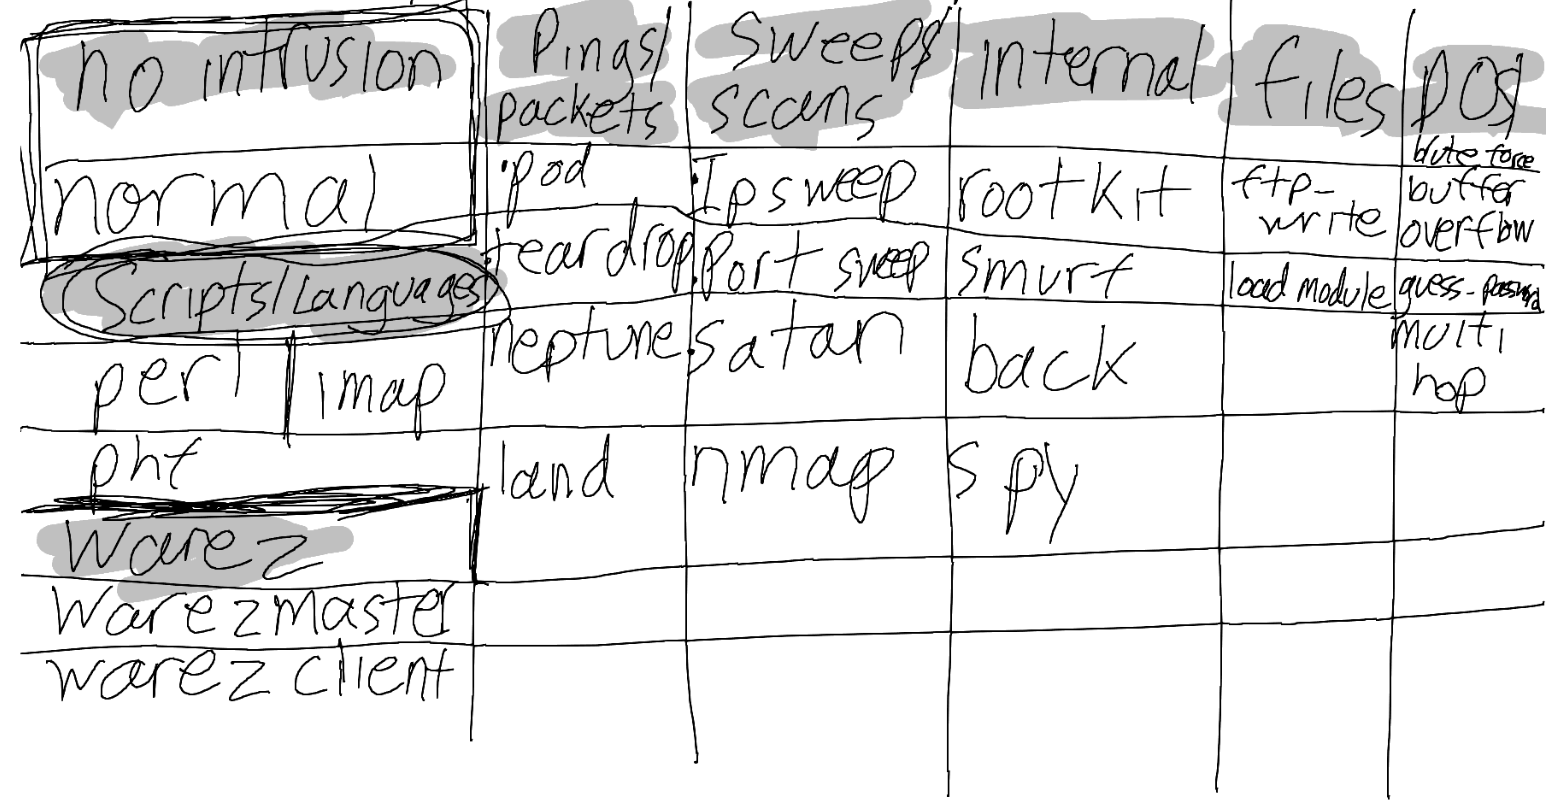

In [18]:
display.Image('./notebooks/Supernote/Potential Cluster Groupings.png')

After splitting up the different intrusions into categories represented by the highlighted boxes above, it appeared that there were 8 tentative categories based on a casual sort through the types. While there is nothing definitive about this sort, it should give us an insight to put 8 firmly within the range of number of clusters that we try. After trying a range of 10 values, my computer wasn't able to make it through one iteration of the loop for 160 minutes. I'm now trying with significantly less iterations in the loop, less iterations in the cluster formula and my GPU instead of CPU. 

In [ ]:
# Initialize cost list
cost = []

# Iterate for different amounts of centroids
for k in tqdm(range(6,11)):
    # Use K-Prototype to generate a model. These parameters can change but hopefully we find something good
    cluster_labels = KPrototypes(n_clusters = k, init = 'Cao', n_init = 10, verbose = 0).fit_predict(X, categorical = cat_col_index)
    # Append cost to the cost list for graphing later
    cost.append(cluster_labels.cost_) 

plt.plot(x = range(6,11), y = cost, marker = 'o')